In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [26]:
experiment_name = 'F-DENSER 10'
statistics_file = 'D:/experiments/' + experiment_name + '/statistics.pkl'

with open(statistics_file, 'rb') as f:
	stat = pickle.load(f)

def to_numpy(list_of_lists):
	for i in range(0, len(list_of_lists)):
		if len(list_of_lists[i]) > 5:
			list_of_lists[i] = list_of_lists[i][0:5]
	return np.array(list_of_lists)

def hms(seconds):
	return time.strftime("%H:%M:%S", time.gmtime(seconds))


F-DENSER 10: 44 generations
225 evaluations (0 for k-folds), 37 cache hits, 32 invalid
runtime 01:33:47, evaluation time 01:52:28 (this run 01:33:41), k-folds: 00:00:00 (this run 00:00:00)


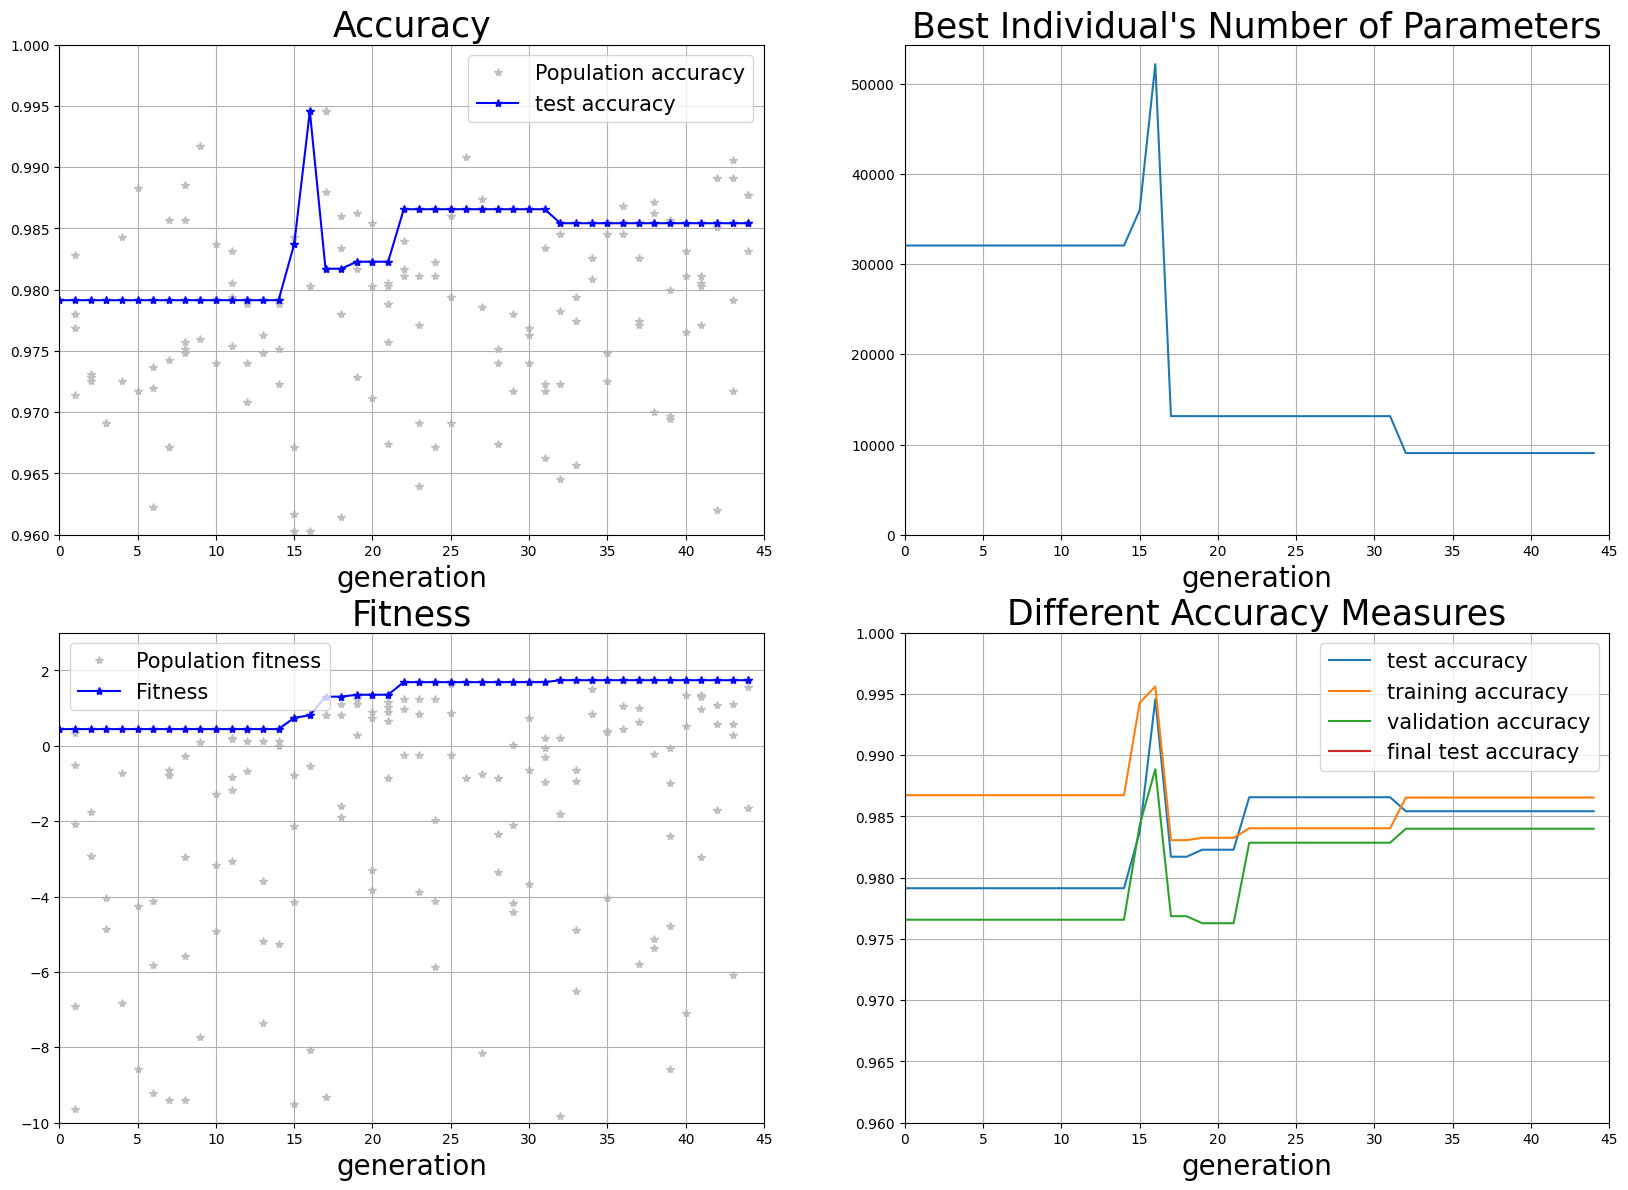

In [27]:
print(f"{experiment_name}: {stat.run_generation} generations")
print(f"{stat.evaluations_total} evaluations ({stat.evaluations_k_folds} for k-folds), {stat.evaluations_cache_hits} cache hits, {stat.evaluations_invalid} invalid")
print(f"runtime {hms(stat.run_time)}, evaluation time {hms(stat.eval_time)} (this run {hms(stat.eval_time_this_run)}), k-folds: {hms(stat.eval_time_k_folds)} (this run {hms(stat.eval_time_k_folds_this_run)})")

# show label for 'Population accuracy' only once
def reduced_legend(ax, population_size):
	handles, labels = ax.get_legend_handles_labels()
	display = (0,population_size)
	ax.legend([handle for i,handle in enumerate(handles) if i in display],
				[label for i,label in enumerate(labels) if i in display], loc = 'best', fontsize=15)

generation_accuracy = to_numpy(stat.generation_accuracy)
(ngenerations, population_size) = generation_accuracy.shape
xscale = np.arange(0, ngenerations)

fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,14))

ax.set_title('Accuracy', fontsize=25)
ax.set_xlabel("generation", fontsize=20)

for i in range(population_size):
	ax.plot(generation_accuracy[:, i], '*',color ='#C0C0C0',label = 'Population accuracy',zorder=-32)
if len(stat.k_fold_accuracy):
	ax.plot(xscale, stat.k_fold_accuracy, 'b*-', label="K-fold accuracy")
	ax.errorbar(xscale, stat.k_fold_accuracy, yerr = stat.k_fold_accuracy_std, ecolor='b', zorder=10)
else:
	ax.plot(stat.accuracy, 'b*-', label="test accuracy")
ax.set_ylim(0.96, 1.0)
ax.set_xlim(0, ngenerations)
reduced_legend(ax, population_size)
ax.grid(True)

ax2.set_title("Best Individual's Number of Parameters", fontsize=25)
ax2.set_xlabel("generation", fontsize=20)
ax2.plot(stat.parameters, label="parameters")
ax2.set_xlim(0, ngenerations)
ax2.set_ylim(0)
ax2.grid(True)

ax3.set_title('Fitness', fontsize=25)
ax3.set_xlabel("generation", fontsize=20)
generation_fitness = to_numpy(stat.generation_fitness)
(ngenerations, population_size) = generation_fitness.shape
xscale = np.arange(0, ngenerations)
for i in range(population_size):
	ax3.plot(generation_fitness[:, i], '*',color ='#C0C0C0',label = 'Population fitness',zorder=-32)
ax3.plot(stat.fitness, 'b*-', label="Fitness")
if stat.k_fold_fitness_std:
	ax3.errorbar(xscale, stat.fitness, yerr = stat.k_fold_fitness_std, ecolor='b', zorder=10)
ax3.set_ylim(-10, 3)
ax3.set_xlim(0, ngenerations)
reduced_legend(ax3, population_size)
ax3.grid(True)

ax4.set_title('Different Accuracy Measures', fontsize=25)
ax4.set_xlabel("generation", fontsize=20)
if len(stat.k_fold_accuracy):
	ax4.plot(xscale, stat.k_fold_accuracy, 'b*-', label="avg K-fold accuracy")
	ax4.errorbar(xscale, stat.k_fold_accuracy, yerr = stat.k_fold_accuracy_std, ecolor='b', zorder=10)
	ax4.plot(stat.k_fold_final_accuracy, label="avg K-fold final accuracy")
ax4.plot(stat.accuracy, label="test accuracy")
ax4.plot(stat.train_accuracy, label="training accuracy")
ax4.plot(stat.val_accuracy, label="validation accuracy")
ax4.plot(stat.final_test_accuracy, label="final test accuracy")
ax4.set_ylim(0.96, 1.0)
ax4.set_xlim(0, ngenerations)
ax4.legend(fontsize=15)
ax4.grid(True)